Blog Link :- https://www.pyimagesearch.com/2016/10/03/bubble-sheet-multiple-choice-scanner-and-test-grader-using-omr-python-and-opencv/

In [1]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from imutils.perspective import four_point_transform
from imutils import contours

In [2]:
"""First will define an answer key which will map the question number to correct answer. Here, we used the indices of options
we get in OMR sheets -> [A, B, C, D, E]"""

# Correct answers of each question are following :-
# Question #1: B
# Question #2: E
# Question #3: A
# Question #4: D
# Question #5: B

Answer_Key = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

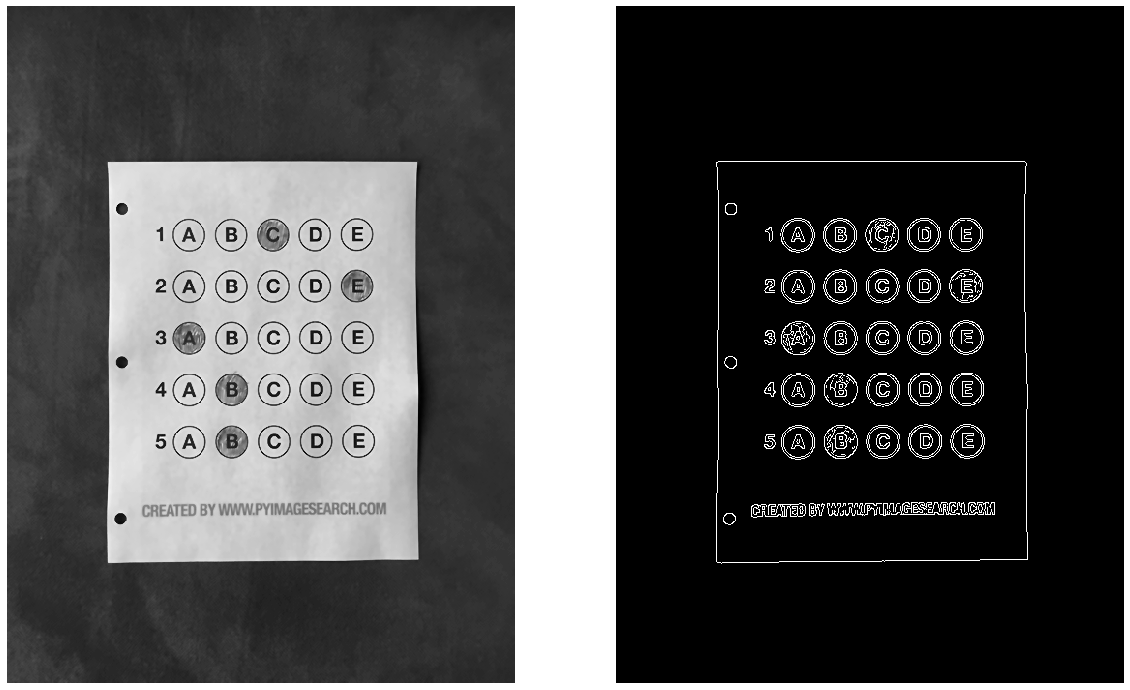

In [3]:
"""Now, let's read the image & after removing some noise by bluring will find the edges of it using cv2.Canny()."""

# Loading the test bubble sheet {Can try all these tests below one by one}:-
# image = cv2.imread("Py_Image_Search/optical-mark-recognition/images/test_01.png")
# image = cv2.imread("Py_Image_Search/optical-mark-recognition/images/test_02.png")
image = cv2.imread("Py_Image_Search/optical-mark-recognition/images/test_03.png")
# image = cv2.imread("Py_Image_Search/optical-mark-recognition/images/test_04.png")
# image = cv2.imread("Py_Image_Search/optical-mark-recognition/images/test_05.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Let's remove some noise by blurring image :-
# gaussian_blurred = cv2.GaussianBlur(gray, (5, 5), 0)
bilateral_blurred = cv2.bilateralFilter(gray, 5, 50, 50)

# Let's find out the edges by using cv2.Canny() :-
# gaussian_edged = cv2.Canny(gaussian_blurred, 75, 200)
bilateral_edged = cv2.Canny(bilateral_blurred, 50 , 255)

fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(bilateral_blurred, cmap='gray')
ax[0].axis("off")
ax[1].imshow(bilateral_edged, cmap='gray')
ax[1].axis("off")
plt.show()

Perimeter of the Longest Contour 1475.9411249160767

 Contours having approx same length like perimeter :-
 [[[103 161]]

 [[103 574]]

 [[425 572]]

 [[424 162]]]


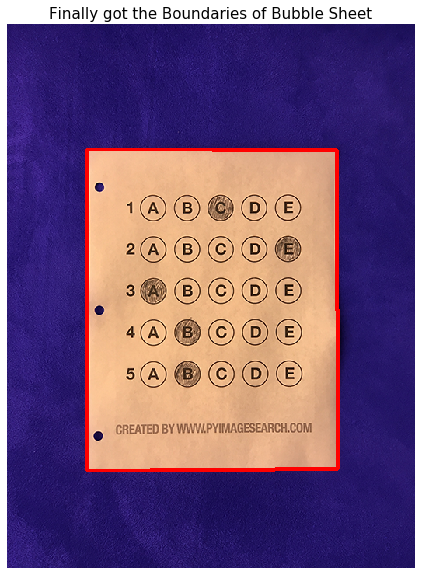

In [4]:
"""Now, will first only try to get the layout of the page and not the background. For that will find the contours.
{To know about Contours scroll down to Notes}"""

conts = cv2.findContours(bilateral_edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
docCnt = None

# Here, we are just ensuring that atleast one contour is found & then will sort the contours in descending order
if len(conts) > 0:
    conts = sorted(conts, key=cv2.contourArea, reverse=True)

for c in conts:
    perimeter = cv2.arcLength(c, True)  # {To know about this function scroll down to Notes}
    print("Perimeter of the Longest Contour",perimeter)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)  # {To know about this function scroll down to Notes}
    print("\n Contours having approx same length like perimeter :-\n", approx)
    docCnt = approx
    break

# Visualizing the Boundaries of Bubble Sheet :-
image_copy = image.copy()
cv2.drawContours(image_copy, [docCnt], 0, (255, 0, 0), 4)
plt.figure(figsize=(10,10))
plt.imshow(image_copy)
plt.title("Finally got the Boundaries of Bubble Sheet", fontsize=15)
plt.axis("off")
plt.show()

**Now that we have used contours to find the outline of the exam, we can apply a perspective transform to obtain a top-down, birds-eye-view (means 90 degree angle view of the exam paper) of the document:**

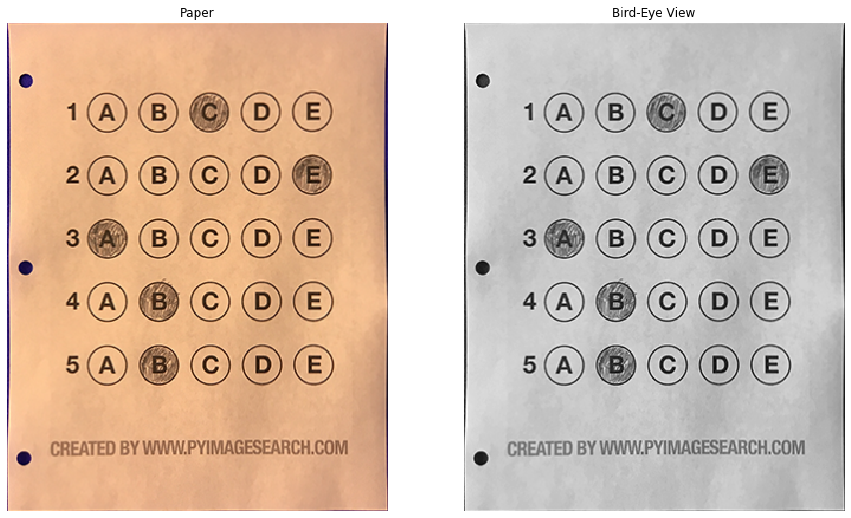

In [5]:
# {To know about four_point_transform() scroll down to Notes}
paper = four_point_transform(image, docCnt.reshape(4,2))
wrapped = four_point_transform(gray, docCnt.reshape(4,2))

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(paper)
ax[0].axis("off")
ax[0].set_title("Paper")
ax[1].imshow(wrapped, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Wrapped")
plt.title("Bird-Eye View")
plt.show()

**Now, will apply the steps of Binarization or Thresholding/Segentation of Foreground from the Background of the image.**

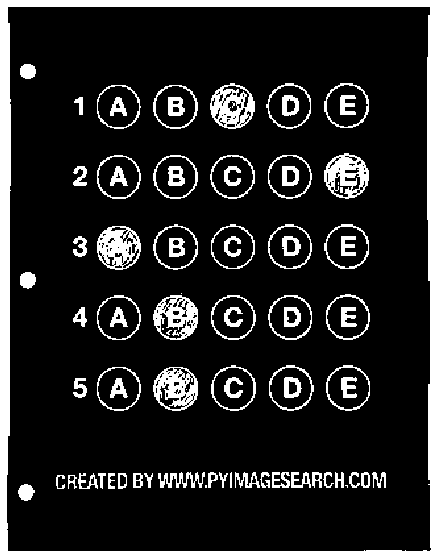

In [6]:
thresh = cv2.threshold(wrapped, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap="gray")
plt.axis("off")
plt.show()

**This Binarization process enables us to find contours once again but this time to get the contours of Bubbles.**

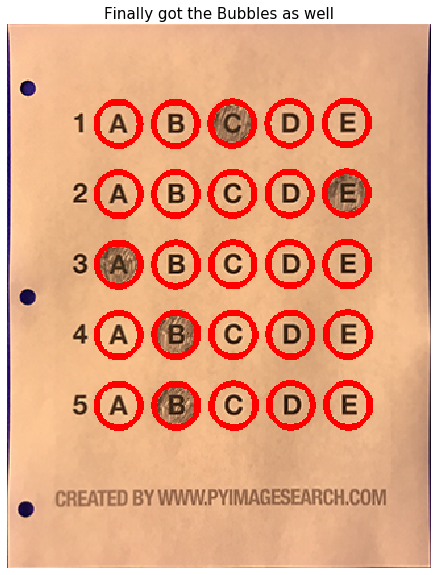

In [7]:
conts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
question_conts = []

for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)  # {To know about cv2.boundingRect() scroll down to Notes}
    aspect_ratio = w/ float(h)
    
    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and aspect_ratio >= 0.9 and aspect_ratio <= 1.1:
        question_conts.append(c)

# Visualizing the contours on each Bubble :-
paper_copy = paper.copy()
for i in range(0, len(question_conts)):
    cv2.drawContours(paper_copy, [question_conts[i]], 0, (255,0,0), 3)

plt.figure(figsize=(10,10))
plt.imshow(paper_copy)
plt.title("Finally got the Bubbles as well", fontsize=15)
plt.axis("off")
plt.show()

In [8]:
# Sorting the question contours from top-to-bottom { To know about contours.sort_contours() scroll down to Notes} :-
question_conts = contours.sort_contours(question_conts, method="top-to-bottom")[0]
conts_of_each_question = []
correct = 0
paper_copy = paper.copy()

# Each question has 5 possible answers, so, will loop over the question in batches of 5 :-
for (q, i) in enumerate(np.arange(0, len(question_conts), 5)):
    # {To know about np.arange() & enumerate() functions scroll down to Notes}    
    
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    conts = contours.sort_contours(question_conts[i:i + 5], method="left-to-right")[0]
    conts_of_each_question.append(list(conts))
    bubbled = None

# Visualization of each Bubble according to Questions is in next cell.

    # loop over the sorted contours
    for (j, c) in enumerate(conts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

# uncomment this to see how 2 for loops give us contours one by one of each question
#         cv2.imshow("mask", mask)
#         cv2.waitKey(0)
# cv2.destroyAllWindows()

        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)  # To know about this scroll down to Notes Section
        total = cv2.countNonZero(mask)

        # The more non-zero pixels we count, then the more
        # foreground pixels there are, and therefore the bubble
        # with the maximum non-zero count is the index of the bubble
        # that the test taker has bubbled in.
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)

    # initialize the contour color and the index of the *correct* answer
    color = (0, 0, 255)  # red color
    k = Answer_Key[q]

    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)  # green color
        correct += 1

    # draw the outline of the correct answer on the test
    cv2.drawContours(paper_copy, [conts[k]], -1, color, 3)

# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.imshow("Original", image)
cv2.imshow("Exam", paper_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] score: 60.00%


# Notes :-

**1. Contours ->** are defined as the line joining all the points along the boundary of an image that are having the same intensity. Contours come handy in shape analysis, finding the size of the object of interest & in object detection.<br><br>

**2. cv2.arcLength() ->** is used to calculate the length/perimeter of contour/curve.<br><br>

**3. cv2.approxPolyDP() ->** finds those contours whoes perimeter is also equal or very near to the precision().<br><br>

**4. four_point_transform() ->**<br><br>

**5. cv2.boundingRect(contours) ->** function of OpenCV is used to draw an approximate rectangle around the contour in binary image. See Documentation for more :- [ https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html ]

**6. imutils.contours.sort_contours() ->** is a function made by Adrian Rosebrock owner of PyImageSearch & library imutils.<br>
This function helps in sorting the contours using the cv2.contourArea() & cv2.boundingRect() according to the direction we specify { "top-to-bottom", "bottom-to-top", "left-to-right"(default), "right-to-left" } & returns(contours, boundingBoxes).<br><br>

**7. np.arange(starting_number, ending_number, intervals) ->** Returns an array with evenly spaced elements as per the interval. Lets see it's example -><br> 
**7.1.** np.arange(4) = array([0, 1, 2, 3])<br> 
**7.2.** np.arange(4, 21) = array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])<br>
**7.3.** np.arange(4, 21, 4) = array([ 4,  8, 12, 16, 20])<br>
**Now, lets see what it could have returned above when we used np.arange() after sorting the bubble contours from "top-to-bottom". :-**<br>
**np.arange(0, len(question_conts), 5)** Resulted -> **[0, 5, 10, 15, 20]**<br><br>

**8. enumerate(iterable) ->** Returns an enumerator object. To see it we can convert it into a list. This will return us a list where each element of our iterable(we supplied) is inside a tupple with its indices. For example :- Above we used enumerate() function after sorting the bubble contours from "top-to-bottom". Let's see what it returned over there :-<br>
**list(enumerate(np.arange(0, len(question_conts), 5)))** Resulted -> **[(0, 0), (1, 5), (2, 10), (3, 15), (4, 20)]**<br><br>

**9. bitwise_and ->** works exactly like (bitwise and) operator. It takes two 2 arguments(or numbers) & then from there binary no.
comparison it returns the number which is formed. Like comparing (2 & 3) there binary number is (000010 & 000011) & after
comparison will return (000010) becoz we are using (and) operator [it gives 1 only when both numbers have 1 on that same 
index no. otherwise returns 0]. So, if u calculate you will also see that after comparing binary numbers of (12 & 13) the 
new binary number which is formed is of 12 itself. Just like this if bitwise_and() is applied on lists the numbers which are
on same index will be compared. In this way by comparing two images only those things will be returned which are common in 
both.

## Following was the code just for Visualizing all Bubbles separately according to each Question :-

In [9]:
# # sorting the question contours from top-to-bottom :-
# question_conts = contours.sort_contours(question_conts, method="top-to-bottom")[0]
# conts_of_each_question = []
# correct = 0

# # np.arange(starting_number, ending_number, intervals/gaps)

# # each question has 5 possible answers, to loop over the question in batches of 5
# for (q, i) in enumerate(np.arange(0, len(question_conts), 5)):
#     # np.arange(0, len(question_conts), 5) -> [0, 5, 10, 15, 20]
#     # enumerate resulted -> [(0, 0), (1, 5), (2, 10), (3, 15), (4, 20)]

#     # sort the contours for the current question from
#     # left to right, then initialize the index of the
#     # bubbled answer
#     conts = contours.sort_contours(question_conts[i:i + 5], method="left-to-right")[0]
#     conts_of_each_question.append(list(conts))  # using list() as by default each question contours are in a tupple.
#     bubbled = None

# # From above code I am having a list in which there are 5 lists each containing contours of 5 options(ABCDE). To visualize
# # it's better to join all the 5 lists and combine all 5 questions contours under one single list. This is done here :-
# conts_of_each_question = list(conts_of_each_question[0] + conts_of_each_question[1] + conts_of_each_question[2] + conts_of_each_question[3] + conts_of_each_question[4])

# # Now, we are ready to visualize contours of each Questions separately :-
# paper_copy = paper.copy()
# colors = [(255,0,0), (0,255,0), (0,0,255), (200,100,100), (200,200,0)]
# for i in range(0, len(conts_of_each_question)):
#     if i < 5:
#         cv2.drawContours(paper_copy, [conts_of_each_question[i]], 0, colors[0], 3)
#     elif i >= 5 and i < 10:
#         cv2.drawContours(paper_copy, [conts_of_each_question[i]], 0, colors[1], 3)
#     elif i >= 10 and i < 15:
#         cv2.drawContours(paper_copy, [conts_of_each_question[i]], 0, colors[2], 3)
#     elif i >= 15 and i < 20:
#         cv2.drawContours(paper_copy, [conts_of_each_question[i]], 0, colors[3], 3)
#     elif i >= 20 and i < 25:
#         cv2.drawContours(paper_copy, [conts_of_each_question[i]], 0, colors[4], 3)


# plt.figure(figsize=(10,10))
# plt.imshow(paper_copy)
# plt.title("Finally got the Bubbles as well", fontsize=15)
# plt.axis("off")
# plt.show()